In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from sklearn.metrics import f1_score 
from keras import optimizers
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'


ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
def resize_img(img, target_height=720):
    height, width = img.shape[:2]
    if height <= target_height:
        return img
    target_width = int(width * (target_height / height))
    resized_img = cv2.resize(img, (target_width, target_height))
    return resized_img

def extract_plate(img, text=''):
    plate_cascade = cv2.CascadeClassifier(full_path_cascad)
    plate_img = img.copy()
    roi = img.copy()
    plate = None
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor=1.05, minNeighbors=8)

    width_max = 0
    plate_max = None
    x_max = 0
    y_max = 0

    for (x, y, w, h) in plate_rect:
        a, b = (int(0.1 * h), int(0.1 * w))
        aa, bb = (int(0.1 * h), int(0.1 * w))

        if h > 75:
            b = 0
            bb = 0

        plate = roi[y+a : y+h-aa, x+b : x+w-bb, :]

        if width_max < w:
            plate_max = plate
            width_max = w
            x_max = x
            y_max = y

        cv2.rectangle(plate_img, (x+2, y), (x+w-3, y+h-5), (51,224,172), 3)
    if text != '':
        h = plate_max.shape[0]
        plate_img = cv2.putText(plate_img, text, (x_max, y_max-h//3), 
                                cv2.FONT_HERSHEY_COMPLEX_SMALL , 1.5, (51,224,172), 2, cv2.LINE_AA)
        
    return plate_img, plate_max

def find_contours(dimensions, img):
    i_width_threshold = 6 
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]

    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:16]
    ii = np.dstack([img] * 3)
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs:
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        if (intWidth >= i_width_threshold and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height):
            x_cntr_list.append(intX)

            char_copy = np.zeros((44, 24))
            char = img[intY:intY + intHeight, intX:intX + intWidth]

            if (intWidth >= i_width_threshold and intWidth < lower_width):
                i_char = cv2.resize(char, (intWidth, 42), interpolation=cv2.INTER_LINEAR_EXACT)

                char = np.full((42, 22), 255, dtype=np.uint8)
                begin = int((22 - intWidth) / 2)
                char[:, begin:begin+intWidth] = i_char[:, :]
            else:
                char = cv2.resize(char, (22, 42), interpolation=cv2.INTER_LINEAR_EXACT)
            
            cv2.rectangle(ii, (intX, intY), (intWidth + intX, intY + intHeight), (50,21,200), 2)

            char = cv2.subtract(255, char)

            char_copy[1:43, 1:23] = char
            char_copy[0:1, :] = 0
            char_copy[:, 0:1] = 0
            char_copy[43:44, :] = 0
            char_copy[:, 23:24] = 0

            img_res.append(char_copy)
            if len(img_res) >= 10: break

    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])
    img_res = np.array(img_res_copy)

    return img_res

def segment_to_contours(image):
    new_height = 75
    img_lp = cv2.resize(image, (333, new_height), interpolation=cv2.INTER_LINEAR_EXACT)
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 112, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    LP_WIDTH = img_binary_lp.shape[1]
    LP_HEIGHT = img_binary_lp.shape[0]

    img_binary_lp[0:3, :] = 255
    img_binary_lp[:, 0:3] = 255
    img_binary_lp[new_height-3:new_height, :] = 255
    img_binary_lp[:, 330:333] = 255

    dimensions = [LP_WIDTH/24, LP_WIDTH/8, LP_HEIGHT/3, 2*LP_HEIGHT/3]
    char_list = find_contours(dimensions, img_binary_lp)
    return char_list


In [ ]:
def create_model():
    model = Sequential()
    model.add(Conv2D(16, (24, 24), input_shape=(28, 28, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(37, activation='softmax'))
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizers.Adam(learning_rate=0.00005),
        metrics=['accuracy'])
    return model

def f1score(y, y_pred):
    return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro')

def custom_f1score(y, y_pred):
    return tf.py_function(f1score, (y, y_pred), tf.double)

class stop_training_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy', 0) > 0.9975:
            self.model.stop_training = True

callbacks = [stop_training_callback()]

def train_model(model, train_generator, validation_generator, file_path: str):
    batch_size = 1
    model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        epochs=80,
        verbose=1,
        callbacks=callbacks)
    model.save(filepath=file_path)

def load_model(file_path: str):
    return tf.keras.models.load_model(filepath=file_path)


In [ ]:
def fix_dimension(img): 
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
    return new_img

def predict_result(ch_contours, model):
    dic = {}
    characters = '#0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i, c in enumerate(characters):
        dic[i] = c

    output = []
    for ch in ch_contours:
        img_ = cv2.resize(ch, (28, 28))
        img = fix_dimension(img_)
        img = img.reshape(1, 28, 28, 3)
        y_ = np.argmax(model.predict(img, verbose=0), axis=-1)[0]
        character = dic[y_]
        output.append(character)
        
    plate_number = ''.join(output)
    return plate_number


AM0074BB


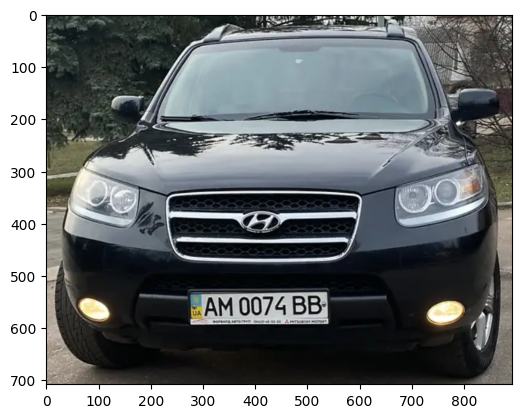

In [ ]:
if __name__ == '__main__':
    models_file_path = './models/'
    file_model = 'ua-license-plate-recognition-model-37x.h5'
    file_cascad = 'haarcascade_russian_plate_number.xml'

    full_path_models = os.path.join(models_file_path, file_model)  
    full_path_cascad = os.path.join(models_file_path, file_cascad)

    model = load_model(full_path_models)

    img_file_path = './img/'
    file_img = 'AM0074BB.png'
    full_path_img = os.path.join(img_file_path, file_img)

    original = cv2.imread(full_path_img)
    resized = resize_img(original)
    img_plate, plate = extract_plate(resized)
    char_contours = segment_to_contours(plate)
    plate_number = predict_result(char_contours, model)
    
    print(plate_number)
    
    plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
    plt.show()
